In [11]:
from pathlib import Path

BASE = Path(r"D:\USTH\MachineLearning in Medicine\x-ray\archive")

def find_infection_root(base: Path) -> Path:
    for p in base.rglob("*"):
        if p.is_dir():
            names = {x.name.lower() for x in p.iterdir() if x.is_dir()}
            if {"train", "val", "test"}.issubset(names):
                return p
    raise FileNotFoundError("Không tìm thấy thư mục chứa Train/Val/Test. Kiểm tra lại BASE.")

ROOT = find_infection_root(BASE / "Infection Segmentation Data")
print("ROOT =", ROOT)
print("Split folders:", [p.name for p in ROOT.iterdir() if p.is_dir()])


ROOT = D:\USTH\MachineLearning in Medicine\x-ray\archive\Infection Segmentation Data\Infection Segmentation Data
Split folders: ['Test', 'Train', 'Val']


In [ ]:
#make pair
from pathlib import Path

ROOT = Path(r"D:\USTH\MachineLearning in Medicine\x-ray\archive\Infection Segmentation Data\Infection Segmentation Data")
CLASSES = ["COVID-19", "Non-COVID", "Normal"]

def collect_pairs(split: str):
    pairs = []
    for cls in CLASSES:
        img_dir = ROOT / split / cls / "images"
        msk_dir = ROOT / split / cls / "infection masks"

        for img_path in img_dir.glob("*.png"):
            mask_path = msk_dir / img_path.name
            if mask_path.exists():
                pairs.append((img_path, mask_path))
    return pairs

train_pairs = collect_pairs("Train")
val_pairs   = collect_pairs("Val")
test_pairs  = collect_pairs("Test")

print("pairs:", len(train_pairs), len(val_pairs), len(test_pairs))
print("example:", train_pairs[0])


pairs: 3728 932 1166
example: (WindowsPath('D:/USTH/MachineLearning in Medicine/x-ray/archive/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images/covid_1.png'), WindowsPath('D:/USTH/MachineLearning in Medicine/x-ray/archive/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/infection masks/covid_1.png'))


In [13]:
#dataset, dataloader
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

IMG_SIZE = 256
BATCH = 8

class CovidInfectionDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img_path, msk_path = self.pairs[idx]

        img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
        msk = Image.open(msk_path).convert("L").resize((IMG_SIZE, IMG_SIZE))

        img = np.array(img, dtype=np.float32) / 255.0
        msk = np.array(msk, dtype=np.float32) / 255.0

        msk= (msk > 0.5).astype(np.float32)

        img = torch.from_numpy(img).unsqueeze(0)
        msk = torch.from_numpy(msk).unsqueeze(0)
        return img, msk
    
train_loader = DataLoader(CovidInfectionDataset(train_pairs), batch_size=BATCH, shuffle=True)
val_loader = DataLoader(CovidInfectionDataset(val_pairs), batch_size=BATCH, shuffle=False)
test_loader = DataLoader(CovidInfectionDataset(test_pairs), batch_size=BATCH, shuffle=False)



In [14]:
#model Unet
import torch.nn as nn
import torch

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

        ) 
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(1, 64); self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(64, 128); self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(128, 256); self.p3 = nn.MaxPool2d(2)
        self.d4 = DoubleConv(256,512); self.p4 = nn.MaxPool2d(2)

        self.mid = DoubleConv(512, 1024)

        self.u4 = nn.ConvTranspose2d(1024, 512, 2, stride=2); self.c4 =  DoubleConv(1024, 512)
        self.u3 = nn.ConvTranspose2d(512, 256, 2, stride=2); self.c3 = DoubleConv(512, 256)
        self.u2 = nn.ConvTranspose2d(256, 128, 2, stride = 2); self.c2 = DoubleConv(256,128)
        self.u1 = nn.ConvTranspose2d(128,64,2,stride=2); self.c1 = DoubleConv(128,64)

        self.out = nn.Conv2d(64,1,1)

    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.p1(x1))
        x3 = self.d3(self.p2(x2))
        x4 = self.d4(self.p3(x3))
        xm = self.mid(self.p4(x4))

        y4 = self.u4(xm); y4 = self.c4(torch.cat([y4, x4], dim = 1))
        y3 = self.u3(y4); y3 = self.c3(torch.cat([y3, x3], dim = 1))
        y2 = self.u2(y3); y2 = self.c2(torch.cat([y2, x2], dim=1))
        y1 = self.u1(y2); y1 = self.c1(torch.cat([y1, x1], dim=1))
        return self.out(y1)

In [15]:
#loss, dice/iou
bce = nn.BCEWithLogitsLoss()

def dice_loss(logits, target, eps=1e-7):
    probs = torch.sigmoid(logits)
    inter = (probs * target).sum(dim=(1,2,3))
    union = probs.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()

def loss_fn(logits, target):
    return 0.5*bce(logits, target) + 0.5*dice_loss(logits, target)

def dice_coef(logits, target, eps=1e-7):
    pred = (torch.sigmoid(logits) > 0.5).float()
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    return ((2*inter + eps) / (union + eps)).mean().item()

def iou_score(logits, target, eps=1e-7):
    pred = (torch.sigmoid(logits) > 0.5).float()
    inter = (pred * target).sum(dim=(1,2,3))
    union = (pred + target - pred*target).sum(dim=(1,2,3))
    return ((inter + eps) / (union + eps)).mean().item()


In [ ]:
#Training model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
from pathlib import Path

if Path("resume_checkpoint.pth").exists():
    ckpt = torch.load("resume_checkpoint.pth", map_location=device)
    model.load_state_dict(ckpt["model"])
    opt.load_state_dict(ckpt["opt"])
    start_epoch = ckpt["epoch"] + 1
    best_dice = ckpt.get("best_dice", -1.0)
    print("Resume from epoch", start_epoch)
else:
    start_epoch = 1
    best_dice = -1.0
    print("Training from scratch")


def run_epoch(loader, train=True):
    model.train(train)
    total_loss = total_dice = total_iou = 0.0
    n = 0

    for imgs, msks in loader:
        imgs, msks = imgs.to(device), msks.to(device)

        with torch.set_grad_enabled(train):
            logits = model(imgs)
            loss = loss_fn(logits, msks)
            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()

        bs = imgs.size(0)
        total_loss += loss.item() * bs
        total_dice += dice_coef(logits.detach(), msks) * bs
        total_iou  += iou_score(logits.detach(), msks) * bs
        n += bs

    return total_loss/n, total_dice/n, total_iou/n

EPOCHS = 15
for epoch in range(start_epoch, EPOCHS+1):
    tr_loss, tr_dice, tr_iou = run_epoch(train_loader, train=True)
    va_loss, va_dice, va_iou = run_epoch(val_loader, train=False)

    #Checkpoint
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "opt": opt.state_dict(),
        "best_dice": best_dice
    }, "resume_checkpoint.pth")

    #Best
    if va_dice > best_dice:
        best_dice = va_dice
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "opt": opt.state_dict(),
            "best_dice": best_dice
        }, "best_checkpoint.pth")
    
    print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} Dice {tr_dice:.4f} IoU {tr_iou:.4f} | "
          f"Val loss {va_loss:.4f} Dice {va_dice:.4f} IoU {va_iou:.4f}")
 

Resume from epoch 10
Epoch 10 | Train loss 0.3700 Dice 0.7457 IoU 0.6875 | Val loss 0.3642 Dice 0.7578 IoU 0.6981
Epoch 11 | Train loss 0.3666 Dice 0.7730 IoU 0.7142 | Val loss 0.3671 Dice 0.8007 IoU 0.7394
Epoch 12 | Train loss 0.3674 Dice 0.7332 IoU 0.6754 | Val loss 0.3605 Dice 0.7430 IoU 0.6861


In [19]:
ckpt = torch.load("best_checkpoint.pth", map_location=device)
model.load_state_dict(ckpt["model"])

print("Loaded BEST model from epoch:", ckpt["epoch"])
print("Best Val Dice:", ckpt["best_dice"])

Loaded BEST model from epoch: 11
Best Val Dice: 0.8006741969882163


In [20]:
te_loss, te_dice, te_iou = run_epoch(test_loader, train=False)
print(f"Test | loss {te_loss:.4f} Dice {te_dice:.4f} IoU {te_iou:.4f}")

Test | loss 0.3716 Dice 0.7917 IoU 0.7313


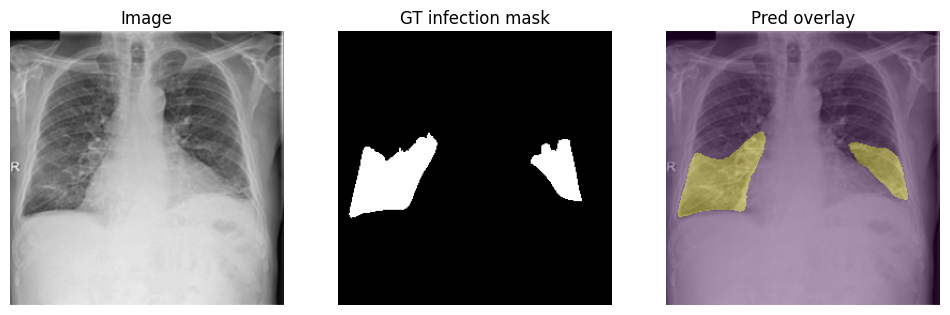

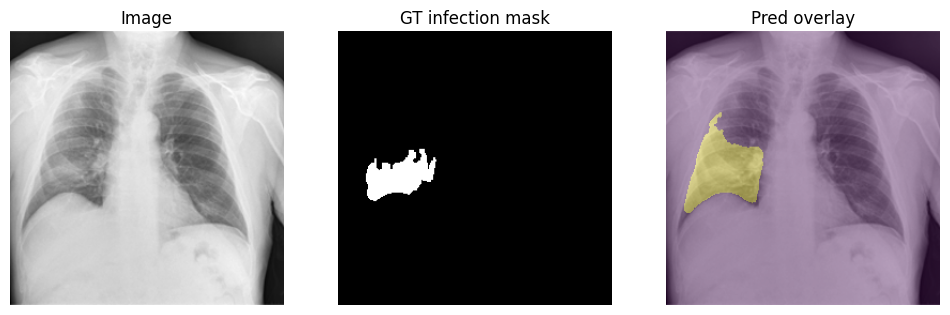

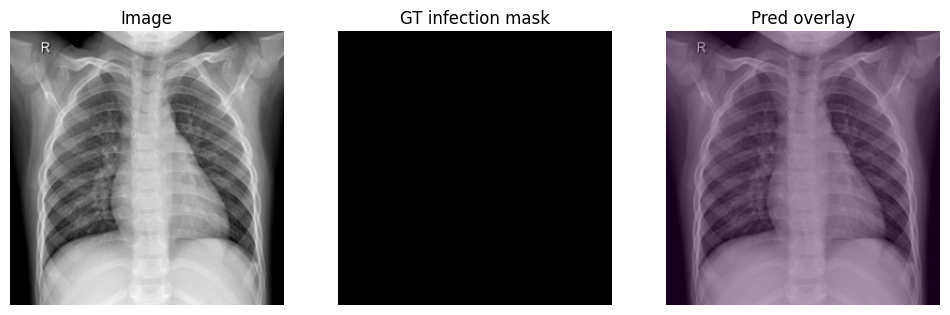

In [24]:
import matplotlib.pyplot as plt
import numpy as np

test_ds = CovidInfectionDataset(test_pairs)

def show_preds(n=3):
    model.eval()
    idxs = np.random.choice(len(test_ds), size=n, replace=False)
    for i in idxs:
        img, gt = test_ds[i]
        with torch.no_grad():
            logits = model(img.unsqueeze(0).to(device))
            pred = (torch.sigmoid(logits).cpu() > 0.7).float().squeeze().numpy()

        img_np = img.squeeze().numpy()
        gt_np  = gt.squeeze().numpy()

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(img_np, cmap="gray"); plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(gt_np, cmap="gray");  plt.title("GT infection mask"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(img_np, cmap="gray"); plt.imshow(pred, alpha=0.35); plt.title("Pred overlay"); plt.axis("off")
        plt.show()

show_preds(3)